# Credit EDA Case Study

#### Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
from datetime import datetime, timedelta, date

##### Setting up the necessary options

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

##### Reading the data set

In [4]:
df = pd.read_csv("application_data.csv")
df_prev= pd.read_csv("previous_application.csv")

In [5]:
print (df.shape)
print (df_prev.shape)

(307511, 122)
(1670214, 37)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


#  Data Cleaning

##### Dropping the unwanted columns


In [7]:
df.drop(df.loc[:, 'EXT_SOURCE_1':'DEF_60_CNT_SOCIAL_CIRCLE'].columns, axis = 1,inplace=True) 
df.drop(df.loc[:, 'FLAG_DOCUMENT_2':'FLAG_DOCUMENT_21'].columns, axis = 1,inplace=True) 
df.drop(df.loc[:, 'FLAG_MOBIL': 'FLAG_EMAIL'].columns, axis = 1,inplace=True) 

In [8]:
df.shape

(307511, 42)

In [9]:
pd.set_option('float_format', '{:f}'.format)
df["AMT_INCOME_TOTAL"].describe()

count      307511.000000
mean       168797.919297
std        237123.146279
min         25650.000000
25%        112500.000000
50%        147150.000000
75%        202500.000000
max     117000000.000000
Name: AMT_INCOME_TOTAL, dtype: float64

##### Changing Data types -

In [10]:
flag_map = {"Y":1,"N":0}
df["FLAG_OWN_CAR"] = df["FLAG_OWN_CAR"].map(flag_map)
df["FLAG_OWN_REALTY"]= df["FLAG_OWN_REALTY"].map(flag_map)
df["DAYS_REGISTRATION"]=df["DAYS_REGISTRATION"].astype(int)

##### Checking for missing values

In [11]:
empty = df.isnull().sum()[df.isnull().sum()>0]
empty.sort_values(ascending = False)

OWN_CAR_AGE                   202929
OCCUPATION_TYPE                96391
AMT_REQ_CREDIT_BUREAU_YEAR     41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
AMT_REQ_CREDIT_BUREAU_MON      41519
AMT_REQ_CREDIT_BUREAU_WEEK     41519
AMT_REQ_CREDIT_BUREAU_DAY      41519
AMT_REQ_CREDIT_BUREAU_HOUR     41519
NAME_TYPE_SUITE                 1292
AMT_GOODS_PRICE                  278
AMT_ANNUITY                       12
CNT_FAM_MEMBERS                    2
DAYS_LAST_PHONE_CHANGE             1
dtype: int64

## Handling Missing values

### OCCUPATION_TYPE Column

#### Occupation type and Name Income Type are related columns. Majority of null values from Occupation type is where the the income type is Pensioner or Unemployed. So setting the value as same as Name Income Type here

In [12]:
df.loc[((df["NAME_INCOME_TYPE"] == "Pensioner") & (df["OCCUPATION_TYPE"].isna() == True)), "OCCUPATION_TYPE"] = "Pensioner"
df.loc[((df["NAME_INCOME_TYPE"] == "Unemployed") & (df["OCCUPATION_TYPE"].isna() == True)), "OCCUPATION_TYPE"] = "Unemployed"


In [13]:
df["OCCUPATION_TYPE"].isnull().sum()

41012

#### For other rows with null value for Occupation type, set the mode value based on Income type

In [14]:
df_empty_occ = df[df["OCCUPATION_TYPE"].isna() == True]

In [15]:
l = list(df_empty_occ["NAME_INCOME_TYPE"].value_counts().index)
for i in l:
    occ_mode = df[df["NAME_INCOME_TYPE"] == i]["OCCUPATION_TYPE"].mode()[0]
    df.loc[((df["NAME_INCOME_TYPE"] == i) & (df["OCCUPATION_TYPE"].isna() == True)), "OCCUPATION_TYPE"] = occ_mode

In [16]:
df["OCCUPATION_TYPE"].isnull().sum()

0

In [17]:
df[df["OCCUPATION_TYPE"]=='XNA']

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR


##### Organizational type and Name Income Type are related columns. XNA values from ORGANIZATION_TYPE is where the the income type is Pensioner or Unemployed. So setting the value as same as Name Income Type here

In [18]:
df.loc[((df["NAME_INCOME_TYPE"] == "Pensioner") & (df["ORGANIZATION_TYPE"] == "XNA")), "ORGANIZATION_TYPE"] = "Pensioner"
df.loc[((df["NAME_INCOME_TYPE"] == "Unemployed") & (df["ORGANIZATION_TYPE"] == "XNA")), "ORGANIZATION_TYPE"] = "Unemployed"


### AMT_REQ_CREDIT_BUREAU** Columns

###### Since AMT_REQ_CREDIT_BUREAU columns are having large number of missing values , dropping the column

In [19]:
labels = (df.loc[:, 'AMT_REQ_CREDIT_BUREAU_HOUR': 'AMT_REQ_CREDIT_BUREAU_YEAR'].columns)
df.drop(labels, axis = 1,inplace=True) 

### CNT_FAM_MEMBERS Column

##### Column CNT_FAM_MEMBERS filling nulls with mean and changing data type

In [20]:
df["CNT_FAM_MEMBERS"].fillna(df["CNT_FAM_MEMBERS"].mean(),inplace=True)

In [21]:
df["CNT_FAM_MEMBERS"]=df["CNT_FAM_MEMBERS"].astype(int)

### NAME_TYPE_SUITE Column

##### Filling null values for  categorical column  NAME_TYPE_SUITE with Missing and Unknown

In [22]:
df["NAME_TYPE_SUITE"].isna().sum()

1292

In [23]:
df["NAME_TYPE_SUITE"] .fillna("Unknown",inplace=True)

### Handling AMT_GOODS_PRICE

#### AMT_GOODS_PRICE is having null values only for revolving loans. So creating two datasets one for cash loan and one for revolving loan

In [24]:
df_cash_loan = df[df["NAME_CONTRACT_TYPE"] == "Cash loans"]
df_rev_loan = df[df["NAME_CONTRACT_TYPE"] == "Revolving loans"]

In [25]:
pd.set_option('float_format', '{:f}'.format)
df_rev_loan["AMT_GOODS_PRICE"].describe()

count     29001.000000
mean     325724.371573
std      237918.801457
min       45000.000000
25%      180000.000000
50%      270000.000000
75%      360000.000000
max     2250000.000000
Name: AMT_GOODS_PRICE, dtype: float64

#### As the data seems to be having null values, imputing median from the revolving loan data set

In [26]:
df["AMT_GOODS_PRICE"] = df["AMT_GOODS_PRICE"].apply(lambda x: df_rev_loan["AMT_GOODS_PRICE"].median() if pd.isnull(x) == True  else x)

### Handling AMT_ANNUITY

#### AMT_ANNUITY is having null values only for cash loans

In [27]:
df_cash_loan["AMT_ANNUITY"].describe()

count   278220.000000
mean     28244.263958
std      14167.189802
min       1615.500000
25%      18103.500000
50%      26086.500000
75%      35694.000000
max     258025.500000
Name: AMT_ANNUITY, dtype: float64

#### As the data seems to be having null values, imputing median from the cash loan data set

In [28]:
df["AMT_ANNUITY"] = df["AMT_ANNUITY"].apply(lambda x: df_cash_loan["AMT_ANNUITY"].median() if pd.isnull(x) == True  else x)

### CODE_GENDER column

##### Handling XNA values in Gender code - Imputing mode value 

In [29]:
df["CODE_GENDER"] = df["CODE_GENDER"].apply(lambda x: df['CODE_GENDER'].mode()[0] if x == "XNA"  else x)


#### Removing unwanted column NAME_TYPE_SUITE, CNT_FAM_MEMBERS, DAYS_LAST_PHONE_CHANGE, also having null values

In [30]:
df.drop(["NAME_TYPE_SUITE", "CNT_FAM_MEMBERS", "DAYS_LAST_PHONE_CHANGE"], axis = 1,inplace=True) 

In [31]:
empty = df.isnull().sum()
empty.sort_values(ascending = False)

OWN_CAR_AGE                    202929
ORGANIZATION_TYPE                   0
AMT_CREDIT                          0
NAME_FAMILY_STATUS                  0
NAME_EDUCATION_TYPE                 0
NAME_INCOME_TYPE                    0
AMT_GOODS_PRICE                     0
AMT_ANNUITY                         0
AMT_INCOME_TOTAL                    0
REGION_POPULATION_RELATIVE          0
CNT_CHILDREN                        0
FLAG_OWN_REALTY                     0
FLAG_OWN_CAR                        0
CODE_GENDER                         0
NAME_CONTRACT_TYPE                  0
TARGET                              0
NAME_HOUSING_TYPE                   0
DAYS_BIRTH                          0
LIVE_CITY_NOT_WORK_CITY             0
DAYS_EMPLOYED                       0
DAYS_REGISTRATION                   0
DAYS_ID_PUBLISH                     0
OCCUPATION_TYPE                     0
REGION_RATING_CLIENT                0
REGION_RATING_CLIENT_W_CITY         0
WEEKDAY_APPR_PROCESS_START          0
HOUR_APPR_PR

In [32]:
df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'OCCUPATION_TYPE', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE'],
      dtype='object')

### Calculating Age and classifying into buckets

#### Calculating Age from DAYS_BIRTH

In [33]:
def compute_age(delta):
    today = date.today() 
    birth_date = today + timedelta(days=delta)
    age = today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day)) 
    return age

In [34]:
df["Age"] = df["DAYS_BIRTH"].apply(lambda x: compute_age(x))

#### Dropping DAYS_BIRTH column

In [35]:
df.drop(["DAYS_BIRTH"], axis = 1,inplace=True) 

#### Classifying Age into buckets

In [36]:
df['AGE_GROUP'] = pd.cut(df.Age, [0,30,40,50,60,9999], labels = ["<30", '30-40', '40-50', '50-60','60+'])

In [37]:
df['AGE_GROUP'].value_counts()

30-40    83212
40-50    74347
50-60    67864
<30      52964
60+      29124
Name: AGE_GROUP, dtype: int64

#### Dropping Age column

In [38]:
df.drop(["Age"], axis = 1,inplace=True) 

In [39]:
df.shape

(307511, 33)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   SK_ID_CURR                   307511 non-null  int64   
 1   TARGET                       307511 non-null  int64   
 2   NAME_CONTRACT_TYPE           307511 non-null  object  
 3   CODE_GENDER                  307511 non-null  object  
 4   FLAG_OWN_CAR                 307511 non-null  int64   
 5   FLAG_OWN_REALTY              307511 non-null  int64   
 6   CNT_CHILDREN                 307511 non-null  int64   
 7   AMT_INCOME_TOTAL             307511 non-null  float64 
 8   AMT_CREDIT                   307511 non-null  float64 
 9   AMT_ANNUITY                  307511 non-null  float64 
 10  AMT_GOODS_PRICE              307511 non-null  float64 
 11  NAME_INCOME_TYPE             307511 non-null  object  
 12  NAME_EDUCATION_TYPE          307511 non-null

### Car Age

#### Classifying Care Age into buckets

In [41]:
df['CAR_AGE_GROUP'] = pd.cut(df.OWN_CAR_AGE, [0,5,10,20,30,40,50,60,70,80,90,9999], labels = ["<5", '5-10', '10-20', '20-30','30-40', '40-50', '50-60','60-70', '70-80','80-90', '>90'])


### Total Income

#### Classifying Total Income into buckets

In [42]:
df['INCOME_GROUP'] = pd.cut(df['AMT_INCOME_TOTAL'], [0,100000,1000000,3000000,6000000,12000000, 19000000], labels = ["<1L", '1-10L', '10-30L', '30-60L','60-120L','120L+'])

### Days Employed

In [43]:
df['DAYS_EMPLOYED'].describe()

count   307511.000000
mean     63815.045904
std     141275.766519
min     -17912.000000
25%      -2760.000000
50%      -1213.000000
75%       -289.000000
max     365243.000000
Name: DAYS_EMPLOYED, dtype: float64

##### Days Employed has a positive value 365243 for pensioners and unemployed people

In [44]:
#Setting values greater than zero to null to omit those from data analysis
df.loc[df['DAYS_EMPLOYED'] > 0, "DAYS_EMPLOYED"] = np.NaN

#### Classifying Days Employed into buckets

In [45]:
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: abs(x))
df['DAYS_EMPLOYED_GROUP'] = pd.cut(df['DAYS_EMPLOYED'], [0,1000, 3000,6000,9000,12000,15000, 18000], labels = ["<1K", '1K-3K', '3K-6K', '6K-9K', '9K-12K','12K-15K', '15K+'])
df['DAYS_EMPLOYED_GROUP'].value_counts()

1K-3K      101179
<1K         82196
3K-6K       49157
6K-9K       13017
9K-12K       4797
12K-15K      1625
15K+          164
Name: DAYS_EMPLOYED_GROUP, dtype: int64

# DATA VISUALISATION

### Correlation between numeric values

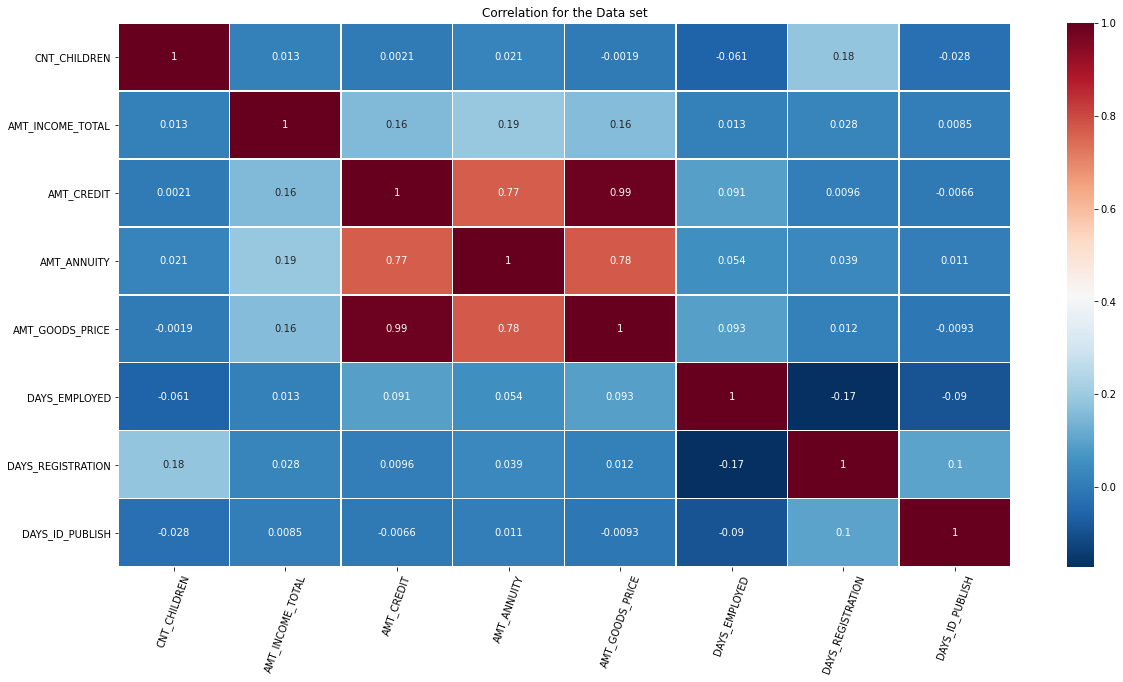

In [46]:
pearsoncorr = df[['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH']].corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,linewidth=0.5)
plt.title('Correlation for the Data set')
plt.xticks(rotation=70)
plt.show()

##### Inference - AMT_CREDIT, AMT_GOODS_PRICE and AMT_ANNUITY are correlated

## Univariate Analysis

In [47]:
sns.set_style('whitegrid')

### Total Income

Text(0.5, 1.0, 'Distribution of Total Income')

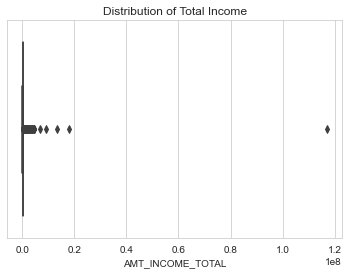

In [48]:
sns.boxplot(data =df, x = 'AMT_INCOME_TOTAL' )
plt.title('Distribution of Total Income')

##### Inference: Outlier detected which on further analysis is suspected to be an erroneous record(abnormally high value with target value as 1 and income type as Labourers). Hence dropping the record

In [49]:
df = df[~(df['AMT_INCOME_TOTAL'] == df['AMT_INCOME_TOTAL'].max())]

In [50]:
df[df["AMT_INCOME_TOTAL"]>4500000]['AMT_INCOME_TOTAL']

77768     9000000.000000
131127    6750000.000000
203693   18000090.000000
246858   13500000.000000
Name: AMT_INCOME_TOTAL, dtype: float64

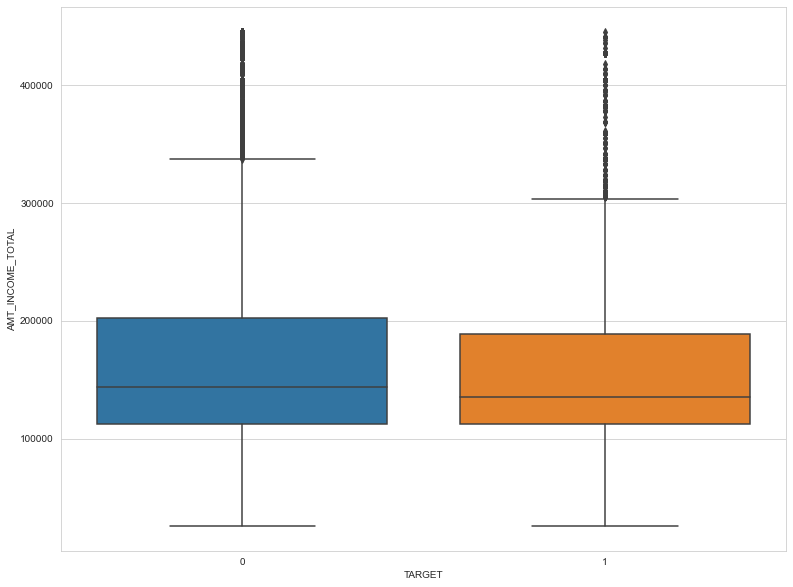

In [51]:
plt.figure(figsize=(13,10))
sns.boxplot(data=df,x='TARGET',y=df[df["AMT_INCOME_TOTAL"]<450000]['AMT_INCOME_TOTAL'])

##### Inferences:
1. Most of the clients are present above median , the third quartile is higher than the first quartile in both target 1 and target 0 case.
2. There are some outliers

### Income Group

Text(0.5, 1.0, 'Distribution of Income Group')

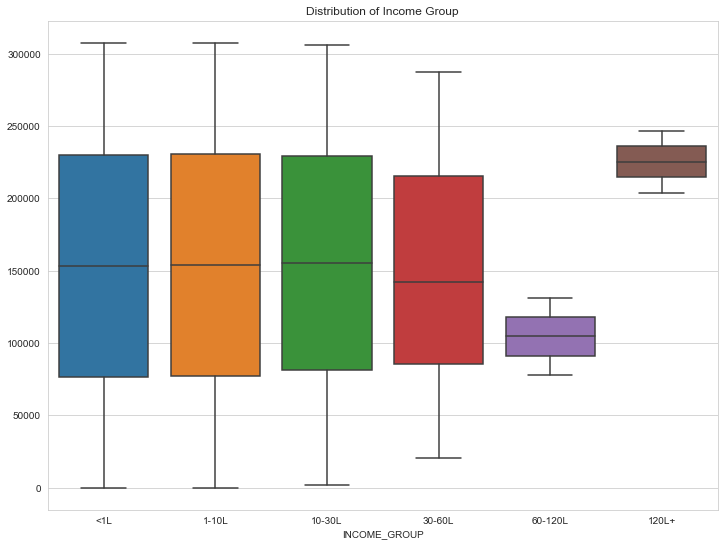

In [52]:
plt.figure(figsize=(12,9))
sns.boxplot(data=df,x=df['INCOME_GROUP'], y=df.index)
plt.title('Distribution of Income Group')

##### Inference: Majority of the applicants are upto the income group of 60L

## Bi-Variate Analysis on Target

### Age Group

Text(0, 0.5, 'TARGET')

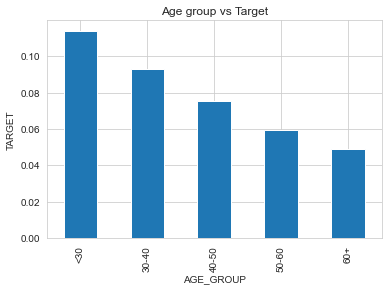

In [53]:
df.groupby('AGE_GROUP')['TARGET'].mean().plot.bar(title = 'Age group vs Target')
plt.ylabel('TARGET')

##### Inference - People with age group <30 seems to have more payment difficulties

### Income Group

Text(0, 0.5, 'TARGET')

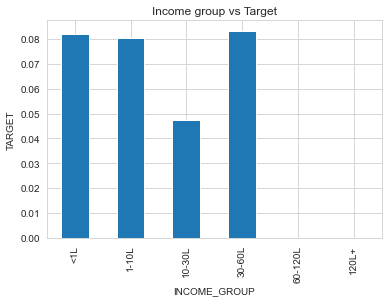

In [54]:
df.groupby('INCOME_GROUP')['TARGET'].mean().plot.bar(title = 'Income group vs Target')
plt.ylabel('TARGET')

##### Inference: People from Income group 60 L and above seems to be probable customers

### Name Contract Type

Text(0, 0.5, 'TARGET')

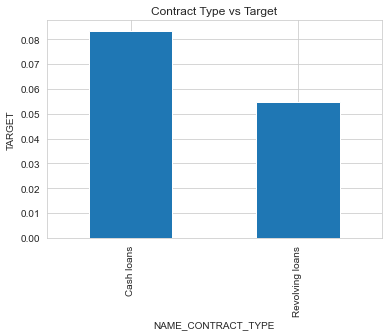

In [55]:
df.groupby('NAME_CONTRACT_TYPE')['TARGET'].mean().plot.bar(title = 'Contract Type vs Target')
plt.ylabel('TARGET')

##### Inference - People who have taken cash loans seems to have more payment difficulties

### Income Type

Text(0, 0.5, 'TARGET')

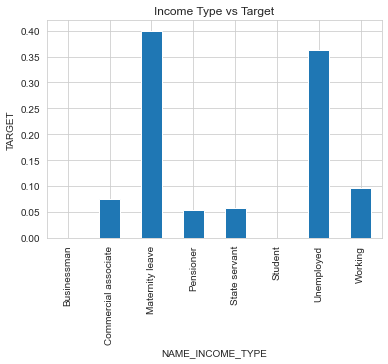

In [56]:
df.groupby('NAME_INCOME_TYPE')['TARGET'].mean().plot.bar(title = 'Income Type vs Target')
plt.ylabel('TARGET')

##### Inference - People who are unemployed and on maternity leave seems to have payment difficulties

### Occupation Type

Text(0, 0.5, 'TARGET')

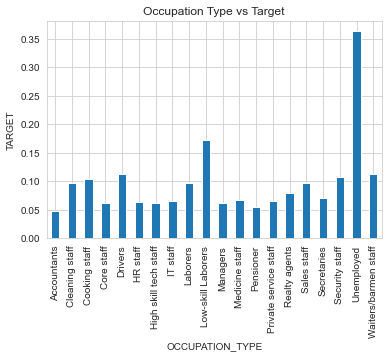

In [57]:
df.groupby('OCCUPATION_TYPE')['TARGET'].mean().plot.bar(title = 'Occupation Type vs Target')
plt.ylabel('TARGET')

##### Inference - Unemployed people and low skill labourers seems to have payment difficulties

### Education Type

Text(0, 0.5, 'TARGET')

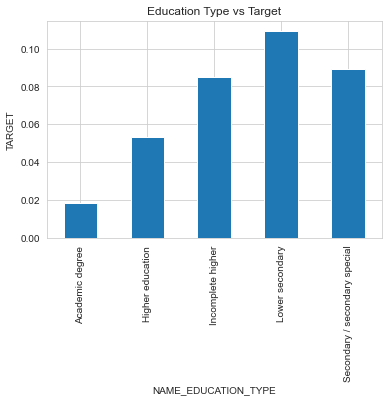

In [58]:
df.groupby('NAME_EDUCATION_TYPE')['TARGET'].mean().plot.bar(title = 'Education Type vs Target')
plt.ylabel('TARGET')

##### Inference: People with education type lower secondary seems to have more payment difficulties

### Housing Type

Text(0, 0.5, 'TARGET')

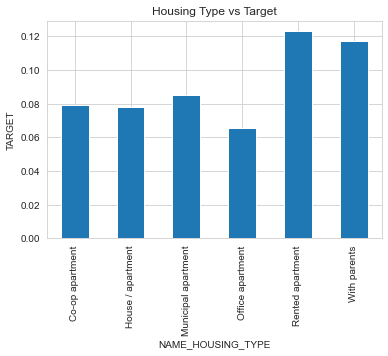

In [59]:
df.groupby('NAME_HOUSING_TYPE')['TARGET'].mean().plot.bar(title = 'Housing Type vs Target')
plt.ylabel('TARGET')

##### Inference: 
##### People who stay in rented apartments or with parents seems to have more payment difficulties

### Car Age Group

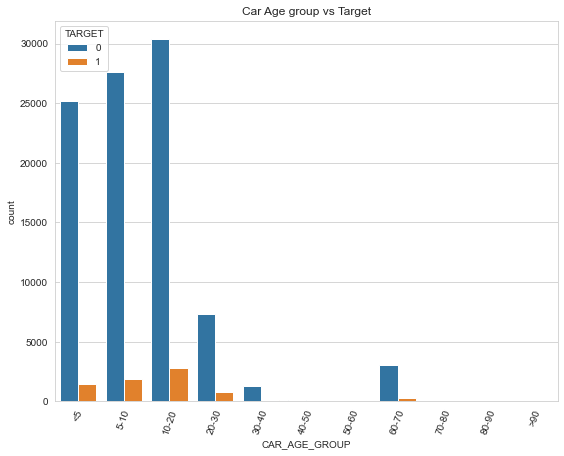

In [60]:
plt.figure(figsize=(9,7))
sns.countplot(df.CAR_AGE_GROUP,hue=df.TARGET)
plt.xticks(rotation=70)
plt.title('Car Age group vs Target')
plt.show()

##### Inference: People having cars with age group below 30 seem to have payment difficulties

### Days Employed

Text(0, 0.5, 'TARGET')

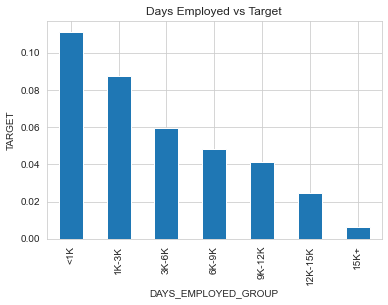

In [61]:
df.groupby('DAYS_EMPLOYED_GROUP')['TARGET'].mean().plot.bar(title = 'Days Employed vs Target')
plt.ylabel('TARGET')

##### Inference: People having lesser days of employment seem to be having payment difficuties

### Gender vs Contract Type

Text(0.5, 0, '(CODE_GENDER, NAME_CONTRACT_TYPE)')

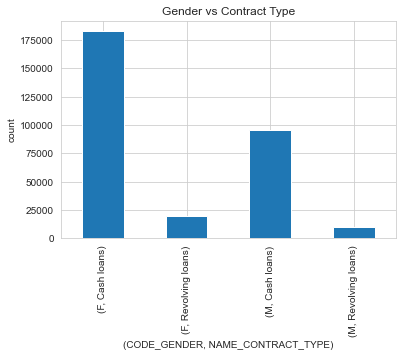

In [62]:
df.groupby(["CODE_GENDER","NAME_CONTRACT_TYPE"])["NAME_CONTRACT_TYPE"].count().plot.bar(title = 'Gender vs Contract Type')
plt.ylabel('count')
plt.xlabel('(CODE_GENDER, NAME_CONTRACT_TYPE)')

##### Inference: 
* Cash loans are outnumbering revolving loans
* In both the categories of contract type, female applicants are outnumbering male applicants

## Multi-Variate Analyis

### Flag Own Realty and Income Type against Target

Text(0, 0.5, 'TARGET')

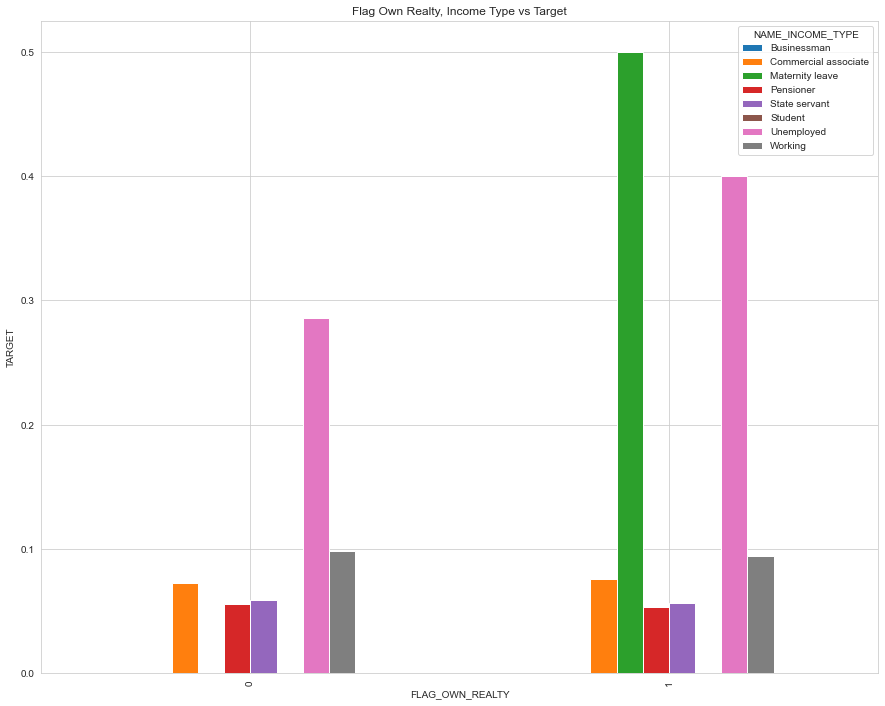

In [63]:
pd.pivot_table(data=df, index = 'FLAG_OWN_REALTY', columns = 'NAME_INCOME_TYPE', values= 'TARGET').plot.bar(title = 'Flag Own Realty, Income Type vs Target',figsize=(15,12))
plt.ylabel('TARGET')

##### Inference: 
Folowing people seem to have payment difficulties:
* People on Materinity leave owning realty
* Unemployed people irrespective of owning realty

### Car Age Group and Income Type against Target

Text(0, 0.5, 'TARGET')

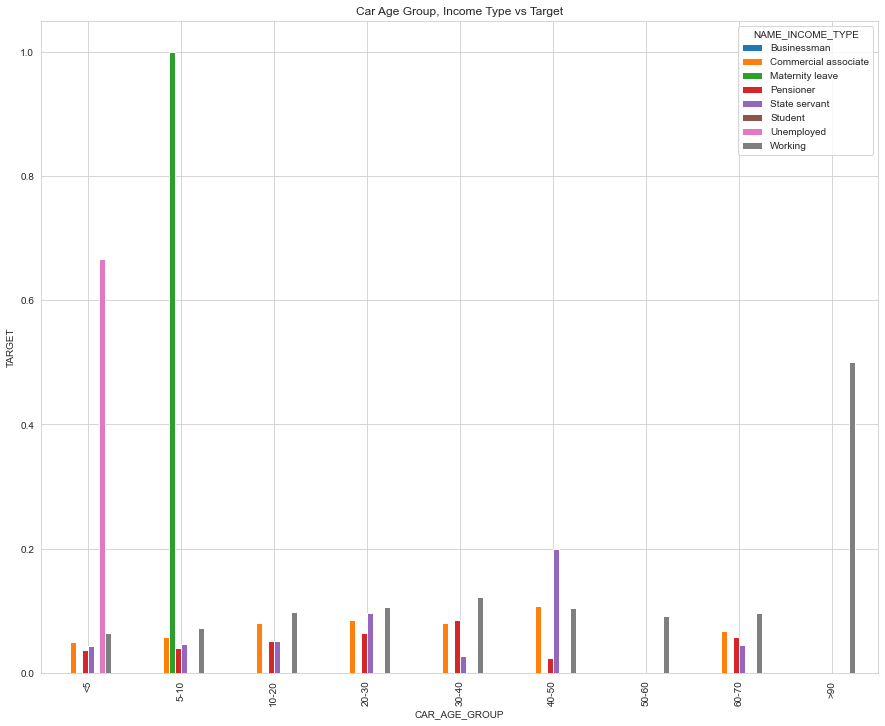

In [64]:
pd.pivot_table(data=df, index = 'CAR_AGE_GROUP', columns = 'NAME_INCOME_TYPE', values= 'TARGET').plot.bar(title= 'Car Age Group, Income Type vs Target',figsize=(15,12))
plt.ylabel('TARGET')

##### Inference: 
Folowing people seem to have payment difficulties:
* People on Maternity leave having a car age less than 10 days
* Unemployed people having a car age less than 5 days

### Flag Own Realty, Car Age Group and Income Type against Target

Text(0, 0.5, 'TARGET')

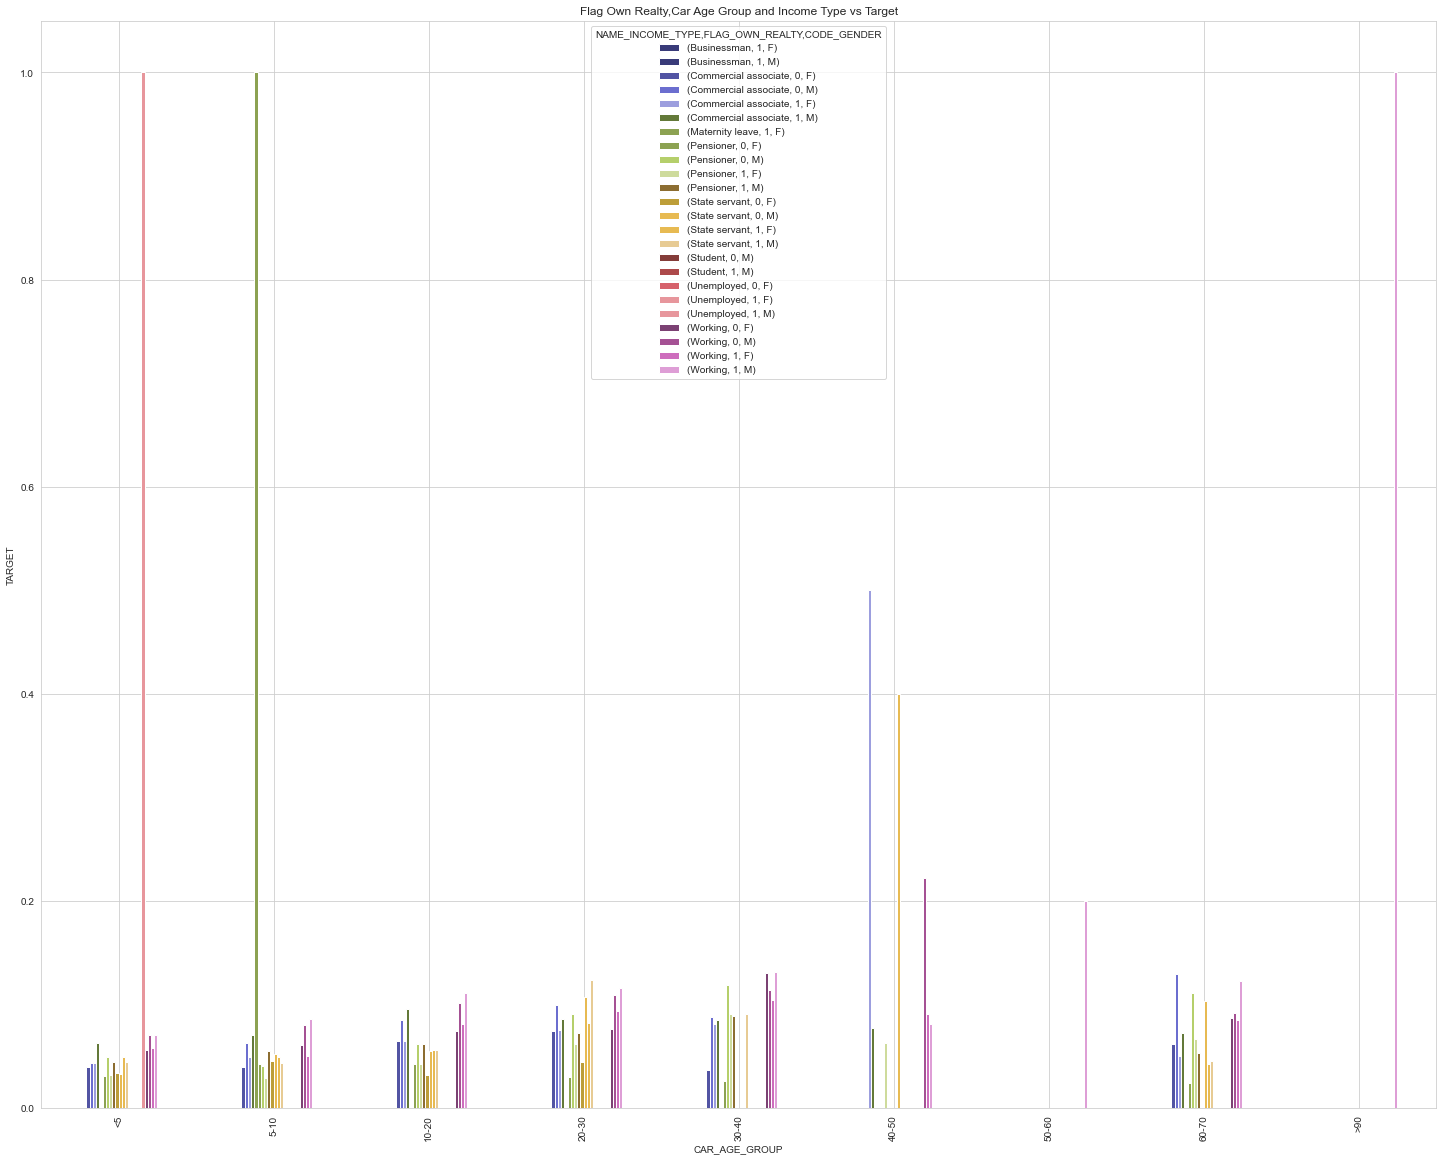

In [95]:
colors = plt.cm.tab20b(np.linspace(0, 1, 25))
pd.pivot_table(data=df, index = 'CAR_AGE_GROUP', columns = ['NAME_INCOME_TYPE', 'FLAG_OWN_REALTY', 'CODE_GENDER'], values= 'TARGET').plot.bar(title='Flag Own Realty,Car Age Group and Income Type vs Target',figsize=(25,20), color = colors)
plt.ylabel('TARGET')

##### Inference: 
Folowing people seem to have payment difficulties:
* People on Maternity leave owning realty and having a car age less than 10 days
* Unemployed people owning realty and having a car age less than 5 days

### Age Group, Income Type and Flag Own Realty against Target

Text(0, 0.5, 'TARGET')

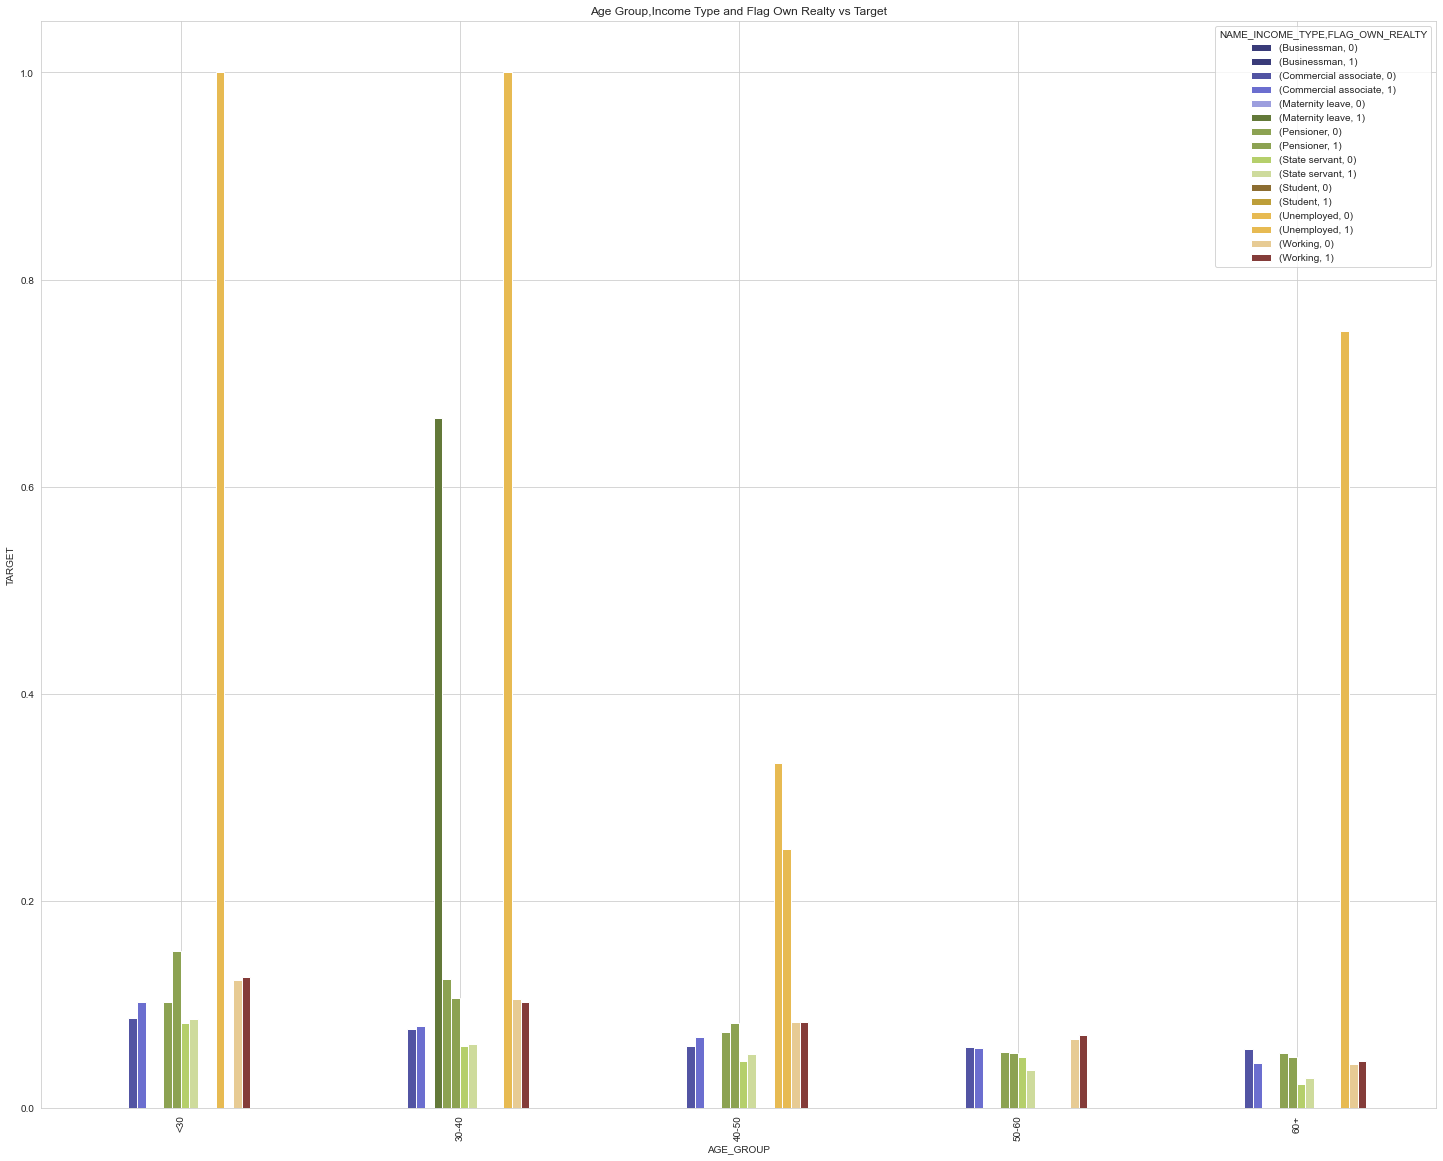

In [96]:
pd.pivot_table(data=df, index = 'AGE_GROUP', columns = ['NAME_INCOME_TYPE', 'FLAG_OWN_REALTY'], values= 'TARGET').plot.bar(title='Age Group,Income Type and Flag Own Realty vs Target',figsize=(25,20), color = colors)
plt.ylabel('TARGET')

##### Inference: 
Following people are having payment difficulties:
* Unemployed people of age group <30 not owning a realty
* Unemployed people of age group 30-40 owning a realty
* People on Maternity leave of age group 30-40 owning realty

### Correlation of the Amount columns

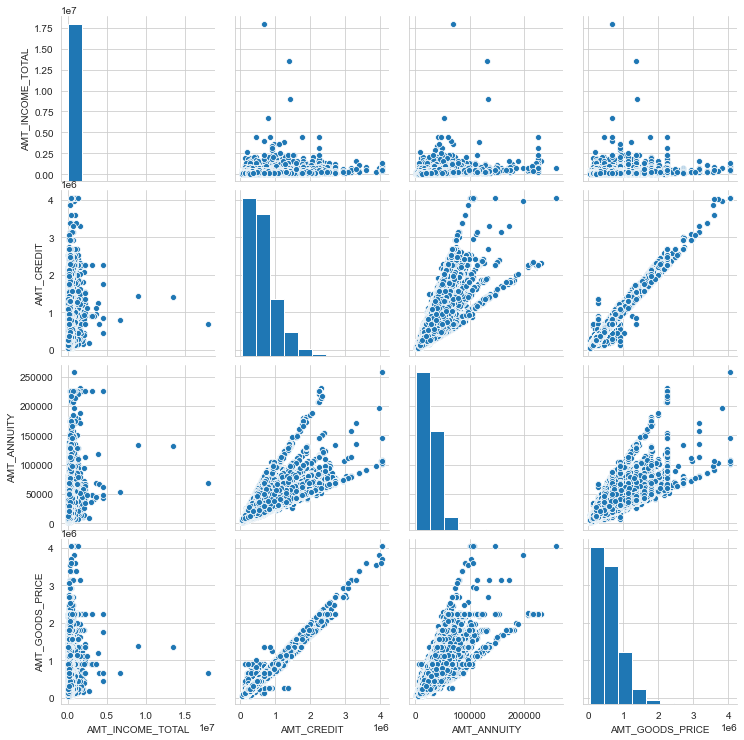

In [67]:
sns.pairplot(data = df, vars=['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY','AMT_GOODS_PRICE'])

##### Inference:
##### Higher the good price , higher is the credit amount and higher the annuity. Goods price, Credit amount and Annuity are linearly related 

### IncomeType and Gender Against Target

Text(0, 0.5, 'TARGET')

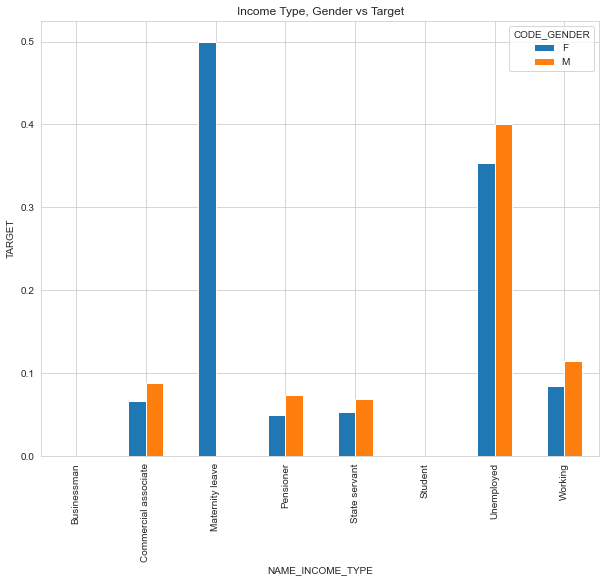

In [68]:
pd.pivot_table(data=df,index = 'NAME_INCOME_TYPE', columns = 'CODE_GENDER',values = 'TARGET').plot.bar(figsize=(10,8), title = 'Income Type, Gender vs Target')
plt.ylabel('TARGET')

##### Inference: Females on maternity leave and Unemployed men seem to be having more payment difficulties

## Previous Application Data

In [69]:
print (df.shape)
print (df_prev.shape)

(307510, 36)
(1670214, 37)


In [70]:
df_prev.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1670214.000000,1670214.000000,1297979.000000,1670214.000000,1670213.000000,774370.000000,1284699.000000,1670214.000000,1670214.000000,774370.000000,5951.000000,5951.000000,1670214.000000,1670214.000000,1297984.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1923089.135331,278357.174099,15955.120659,175233.860360,196114.021218,6697.402139,227847.279283,12.484182,0.996468,0.079637,0.188357,0.773503,-880.679668,313.951115,16.054082,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,532597.958696,102814.823849,14782.137335,292779.762387,318574.616546,20921.495410,315396.557937,3.334028,0.059330,0.107823,0.087671,0.100879,779.099667,7127.443459,14.567288,88916.115834,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1000001.000000,100001.000000,0.000000,0.000000,0.000000,-0.900000,0.000000,0.000000,0.000000,-0.000015,0.034781,0.373150,-2922.000000,-1.000000,0.000000,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1461857.250000,189329.000000,6321.780000,18720.000000,24160.500000,0.000000,50841.000000,10.000000,1.000000,0.000000,0.160716,0.715645,-1300.000000,-1.000000,6.000000,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1923110.500000,278714.500000,11250.000000,71046.000000,80541.000000,1638.000000,112320.000000,12.000000,1.000000,0.051605,0.189122,0.835095,-581.000000,3.000000,12.000000,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2384279.750000,367514.000000,20658.420000,180360.000000,216418.500000,7740.000000,234000.000000,15.000000,1.000000,0.108909,0.193330,0.852537,-280.000000,82.000000,24.000000,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2845382.000000,456255.000000,418058.145000,6905160.000000,6905160.000000,3060045.000000,6905160.000000,23.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,4000000.000000,84.000000,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


In [71]:
df_prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

### Data Cleaning

In [72]:
df_prev.isnull().sum()[df_prev.isnull().sum()>0]

AMT_ANNUITY                   372235
AMT_CREDIT                         1
AMT_DOWN_PAYMENT              895844
AMT_GOODS_PRICE               385515
RATE_DOWN_PAYMENT             895844
RATE_INTEREST_PRIMARY        1664263
RATE_INTEREST_PRIVILEGED     1664263
NAME_TYPE_SUITE               820405
CNT_PAYMENT                   372230
PRODUCT_COMBINATION              346
DAYS_FIRST_DRAWING            673065
DAYS_FIRST_DUE                673065
DAYS_LAST_DUE_1ST_VERSION     673065
DAYS_LAST_DUE                 673065
DAYS_TERMINATION              673065
NFLAG_INSURED_ON_APPROVAL     673065
dtype: int64

#### Dropping columns with most null values

In [73]:
df_prev.drop(df_prev.loc[:,"PRODUCT_COMBINATION":"NFLAG_INSURED_ON_APPROVAL"].columns,axis=1,inplace=True)

In [74]:
df_prev.drop(df_prev.loc[:,"RATE_DOWN_PAYMENT":"RATE_INTEREST_PRIVILEGED"].columns,axis=1,inplace=True)

In [75]:
labels = df_prev.loc[:, 'WEEKDAY_APPR_PROCESS_START' : 'HOUR_APPR_PROCESS_START'].columns
print(labels)
df_prev.drop(labels, axis = 1,inplace=True) 

Index(['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START'], dtype='object')


In [76]:
df_prev.drop(['AMT_DOWN_PAYMENT', 'NAME_TYPE_SUITE'] , axis = 1,inplace=True) 
df_prev.shape

(1670214, 23)

In [77]:
df_prev["NAME_CONTRACT_TYPE"].value_counts()

Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                   346
Name: NAME_CONTRACT_TYPE, dtype: int64

In [78]:
df["NAME_CONTRACT_TYPE"].value_counts()

Cash loans         278231
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

In [79]:
df_prev["NAME_CONTRACT_STATUS"].value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

## Merging both Current and Previous Application Data

In [80]:
merged_df=pd.merge(left=df,right=df_prev,how='inner',on='SK_ID_CURR',suffixes='_x')

In [81]:
merged_df.shape

(1413698, 58)

In [82]:
merged_final = merged_df.rename({'NAME_CONTRACT_TYPE_' : 'NAME_CONTRACT_TYPE','AMT_CREDIT_':'AMT_CREDIT','NAME_CONTRACT_TYPEx':'NAME_CONTRACT_TYPE_PREV',
                         'AMT_CREDITx':'AMT_CREDIT_PREV'}, axis=1)

### Classifying merged data set into two based on the Target Column

In [83]:
df_target0 = merged_final[merged_final["TARGET"]==0]
df_target1 = merged_final[merged_final["TARGET"]==1]

### Target value 1 implies payment difficulties and 0 indicates no payment difficulties. Imbalance of data noticed based on this variable

In [84]:
# Ratio of imbalance in data based on Target variable
target_perc = merged_final['TARGET'].value_counts(normalize=True)
print('Ratio is: ', round(target_perc[0]*100, 2), ':', round(target_perc[1]*100, 2))


Ratio is:  91.34 : 8.66


#### Ratio of imbalance based on Target value is found to be: 91.34 : 8.66

### Client Type and Contract Status against Target

Text(0, 0.5, 'TARGET')

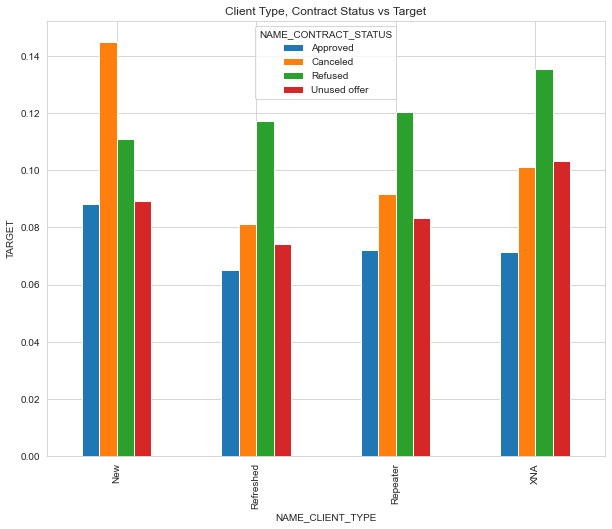

In [85]:
pd.pivot_table(data=merged_final, index = 'NAME_CLIENT_TYPE', columns = 'NAME_CONTRACT_STATUS', values= 'TARGET').plot.bar(figsize=(10,8), title = 'Client Type, Contract Status vs Target')
plt.ylabel('TARGET')

##### Inference: 
* Number of approved requests are lesser compared to other categories for all client types
* More number of cancelled and approved requests observed for new clients
* Number of refused requests seems comparable across all client types

### Contract Status, Client Type against Target

Text(0, 0.5, 'TARGET')

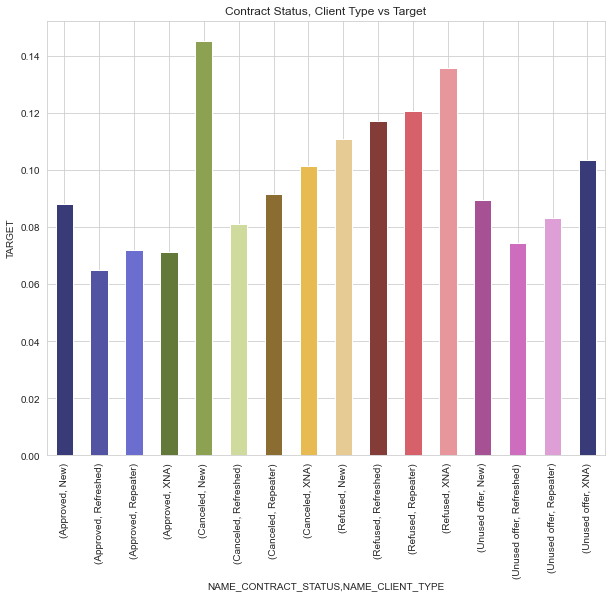

In [86]:
merged_final.groupby(['NAME_CONTRACT_STATUS','NAME_CLIENT_TYPE']).TARGET.mean().plot.bar(title = 'Contract Status, Client Type vs Target',figsize= (10,8), color = colors)
plt.ylabel('TARGET')

##### Inference: 
* New clients with cancelled application status seems to have payment difficulties
* Clients with refused application status seems to be having payment difficulties irrespective of client type

### Loan Purpose against Target

Text(0, 0.5, 'TARGET')

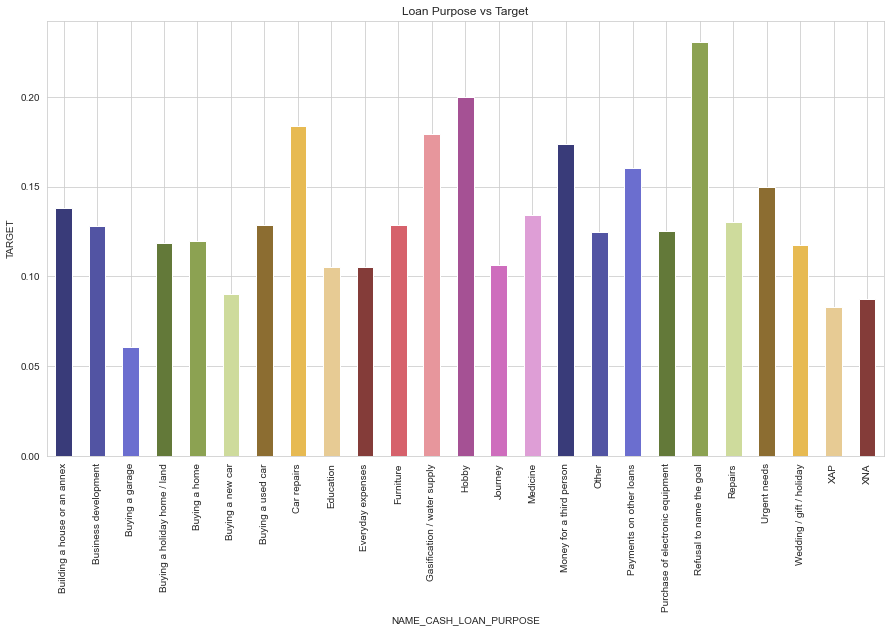

In [87]:
merged_final.groupby('NAME_CASH_LOAN_PURPOSE')['TARGET'].mean().plot.bar(title = 'Loan Purpose vs Target',color = colors, figsize=(15,8))
plt.ylabel('TARGET')

##### Inference: People with loan purposes stated as 'Refusal to name the goal', 'Hobby' and 'Car repairs' seem to be having payment difficulties

### Filter out data set with Refused status 

In [88]:
df_refused= merged_final[merged_final['NAME_CONTRACT_STATUS']=="Refused"]

### Loan Purpose, Rejection Reason against Target

Text(0, 0.5, 'TARGET')

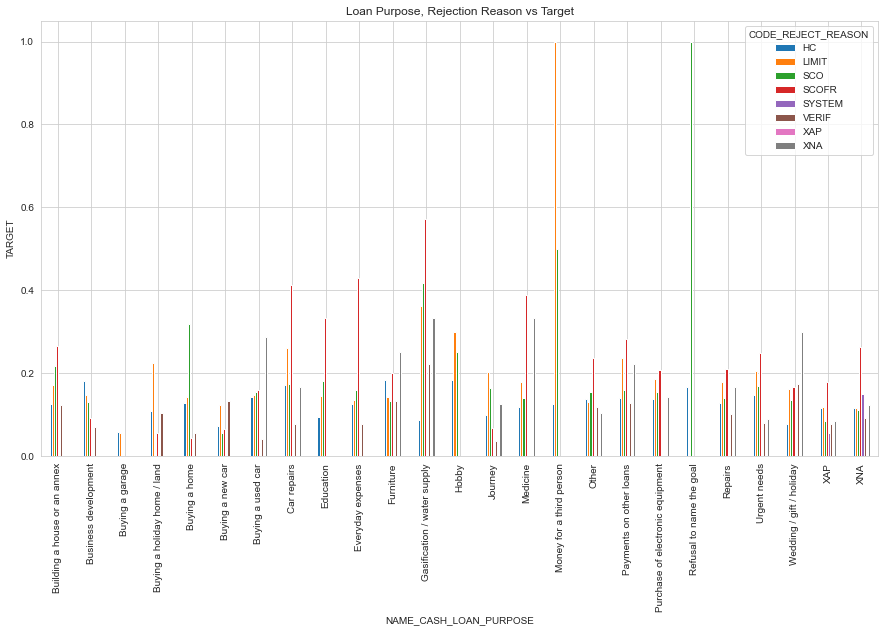

In [89]:
pd.pivot_table(data=df_refused, index = 'NAME_CASH_LOAN_PURPOSE', columns = 'CODE_REJECT_REASON', values= 'TARGET').plot.bar(title = 'Loan Purpose, Rejection Reason vs Target',figsize=(15,8))
plt.ylabel('TARGET')


##### Inference: 
Of the rejected applications, following seem to have payment difficulties:
* Loan purpose as 'Refusal to name the goal' with rejection reason as 'SCO'
* Loan purpose as 'Money for a third person' with rejection reason as 'SCOFR'


### Occupation Type, Rejection Reason against Target

Text(0, 0.5, 'TARGET')

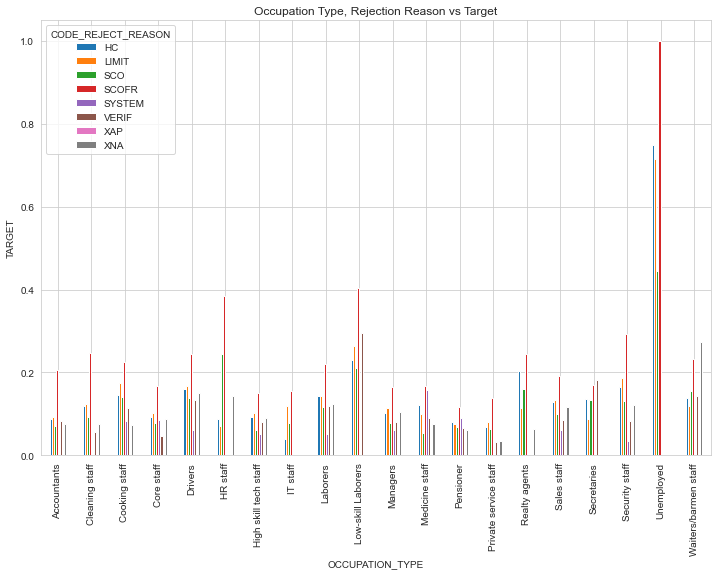

In [90]:
pd.pivot_table(data=df_refused, index = 'OCCUPATION_TYPE', columns = 'CODE_REJECT_REASON', values= 'TARGET').plot.bar(title = 'Occupation Type, Rejection Reason vs Target',figsize=(12,8))
plt.ylabel('TARGET')

##### Inference: Unemployed people with application rejection reason as HC and SCOFR seem to be having more payment difficulties

### Income Group, Rejection Reason against Target

Text(0, 0.5, 'TARGET')

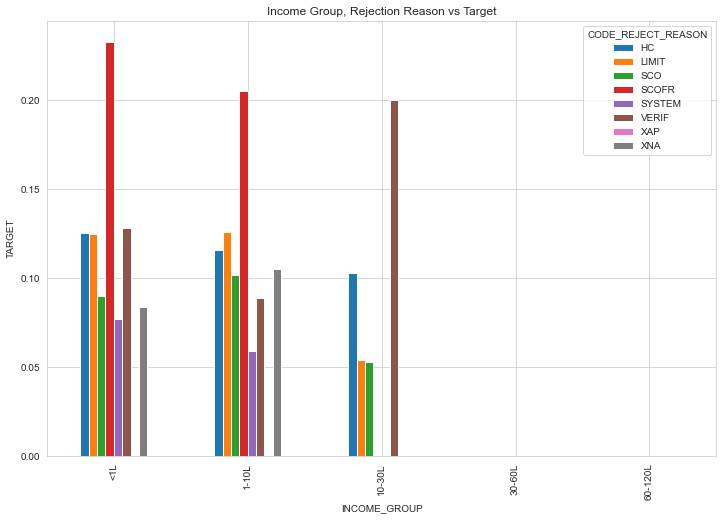

In [91]:
pd.pivot_table(data=df_refused, index = 'INCOME_GROUP', columns = 'CODE_REJECT_REASON', values= 'TARGET').plot.bar(title='Income Group, Rejection Reason vs Target',figsize=(12,8))
plt.ylabel('TARGET')

##### Inference: 
Following seem to be having more payment difficulties:
* People having income less than 10 lakhs with application rejection reason as SCOFR
* People having income between 10-30 lakhs with application rejection reason as VERIF